In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [4]:
sm_refpoints = ps.StanModel(file="stan_files/nn_refpoints_constrainedX.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5085acf5ccddc2f904a6c696ad34fc07 NOW.


In [5]:
M = 1000
Z = 10*npr.rand(2,M)
X = np.zeros((3,M))
X[0] = np.cos(Z[0])*np.cos(Z[1])
X[1] = np.cos(Z[0])*np.sin(Z[1])
X[2] = np.sin(Z[0])

idx = X[2]>0
X = X[:,idx]
Z = Z[:,idx]
X += 0.1*npr.rand(*np.shape(X))
Nobs = np.shape(Z)[1]

### Local linear embedding for reference points:

In [6]:
n_ref = 40
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
X_embedded = embedding.fit_transform(X.transpose()).transpose()

In [7]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
X_ref = X[:,ref_points]
Z_ref = X_embedded[:,ref_points]
X_train = X[:,train]

In [8]:
for i in range(np.shape(Z_ref)[1]) :
    Z_ref[:,i] /= np.linalg.norm(Z_ref[:,i])

In [9]:
n_in = np.shape(X_embedded)[0]
n_h = 50
n_out = np.shape(X)[0]

model = nn.Sequential(nn.Linear(n_in, n_h),
                      nn.Tanh(),
                      nn.Linear(n_h, n_out))

In [10]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=np.shape(Z)[0], 
                      out_dim=np.shape(X)[0], 
                      hidden_dim=n_h,
                      n_ref=np.shape(X_ref)[1],
                      X=X_train, 
                      X_ref=X_ref,
                      Z_ref=Z_ref)

### Run Stan:

In [11]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=6, chains=6,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints_lle);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


782.81 minutes to run
Inference for Stan model: anon_model_5085acf5ccddc2f904a6c696ad34fc07.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]               0.11    0.53   1.04  -1.98  -0.58   0.02   0.75   2.24      4    2.3
X[2,1]              -0.42    0.51   1.02  -2.45  -1.18  -0.37   0.38   1.23      4   2.18
X[3,1]               0.41    0.59   1.16   -1.9  -0.52   0.53   1.28   2.28      4   2.35
X[4,1]              -0.74    0.24   0.61  -1.98  -1.14  -0.75  -0.34   0.33      7    1.5
X[5,1]              -0.71    0.36   0.77  -2.19  -1.26  -0.69  -0.25   0.77      5    1.9
X[6,1]               0.03    0.59   1.13  -2.09  -0.88-4.8e-4   0.94   1.99      4   2.54
X[7,1]              -0.29    0.31   0.69   -1.7  -0.72  -0.33   0.24   0.97      5   1.74
X[8,1]              -0.28    0.31   0.66  -1.52  -0.66  -0.28  -0.02   

In [14]:
trace = fit.extract()
n_samples = np.shape(trace['Z'])[0]
n_latent = np.shape(trace['Z'])[1]

### Traceplots of latent variables:

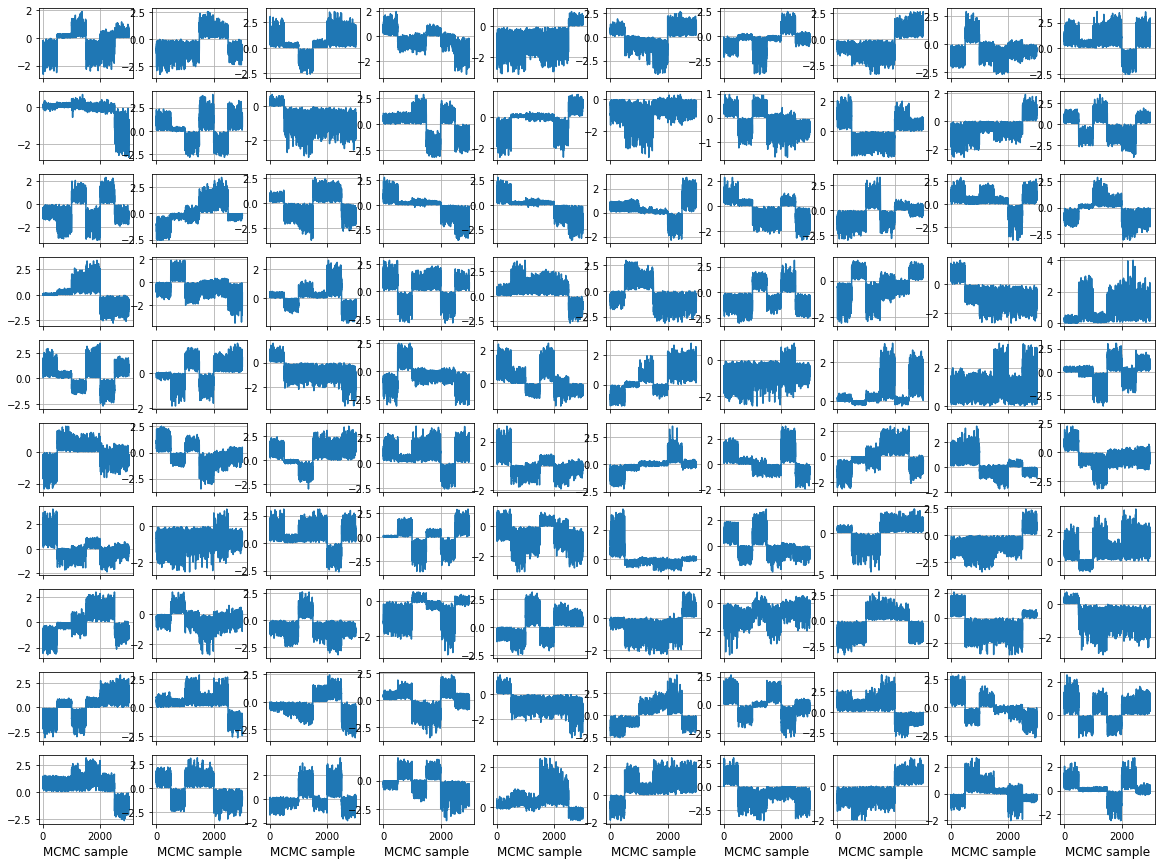

In [15]:
plt.figure(figsize=(20,15))
idx = npr.choice(n_latent,100).reshape(10,10)

for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.plot(trace['Z'][:,idx[i,j],0])
        if i < 9 : plt.xticks(alpha=0)
        if i == 9 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.show()

### Loss:

In [37]:
normedZ = np.zeros((np.shape(trace['Z'])))
for i in range(np.shape(normedZ)[0]) :
    for j in range(np.shape(normedZ)[1]) :
        for k in range(np.shape(normedZ)[2]) :
            normedZ[i,j,k] = trace['Z'][i,j,k]/np.linalg.norm(trace['Z'][i,j])

In [16]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))

100%|██████████| 3000/3000 [00:02<00:00, 1468.35it/s]


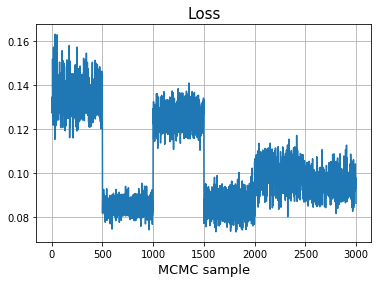

In [39]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(X_train.transpose(), normedZ[i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True);

### Pairwise distances:

In [18]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in trange(100) :
    for j in range(100) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['Z'][k,i]-trace['Z'][k,j])

100%|██████████| 100/100 [02:25<00:00,  1.55s/it]


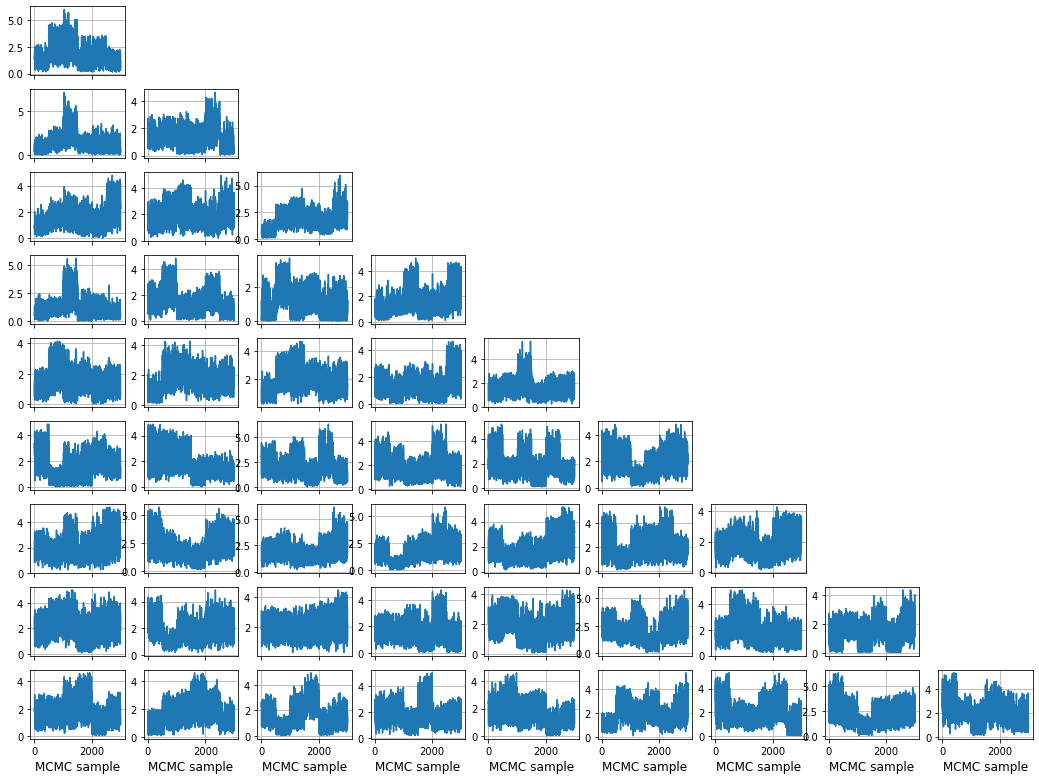

In [19]:
idx = npr.choice(100,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 9 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 9 : plt.xlabel("MCMC sample", fontsize=12)